# Initial Imports

In [26]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from collections import Counter
import random
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend as K
from numba import cuda

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [3]:
# K.clear_session()
# cuda.select_device(0)  # Select your GPU
# cuda.close()

# Data exploration

## Path Setup

In [3]:
data_directory = "data/disasters_dataset"
model_saves_directory = "model-saves"
original_directory = os.path.join(data_directory, "original")
processed_directory = os.path.join(data_directory, "processed")
train_directory = os.path.join(processed_directory, 'train')
test_directory = os.path.join(processed_directory, 'test')
valid_directory = os.path.join(processed_directory, 'valid')

In [4]:
os.makedirs(train_directory, exist_ok=True)
os.makedirs(valid_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

## Disaster statistics and visualization

In [5]:
classes = [folder for folder in os.listdir(original_directory) if os.path.isdir(os.path.join(original_directory, folder))]

print("Classes found:", classes)

Classes found: ['drought', 'earthquake', 'human_damage', 'infrastructure', 'land_slide', 'non_damage_buildings_street', 'non_damage_human', 'non_damage_sea', 'non_damage_wildlife_forest', 'urban_fire', 'water_disaster', 'wild_fire']


In [6]:
def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

data = []

for class_name in classes:
    class_path = os.path.join(original_directory, class_name)
    image_count = count_images_in_folder(class_path)
    data.append({'Class': class_name, 'Image Count': image_count})

class_image_statistic = pd.DataFrame(data)
class_image_statistic

,Class,Image Count
0,drought,201
1,earthquake,174
2,human_damage,240
3,infrastructure,557
4,land_slide,456
5,non_damage_buildings_street,448
6,non_damage_human,120
7,non_damage_sea,569
8,non_damage_wildlife_forest,670
9,urban_fire,419


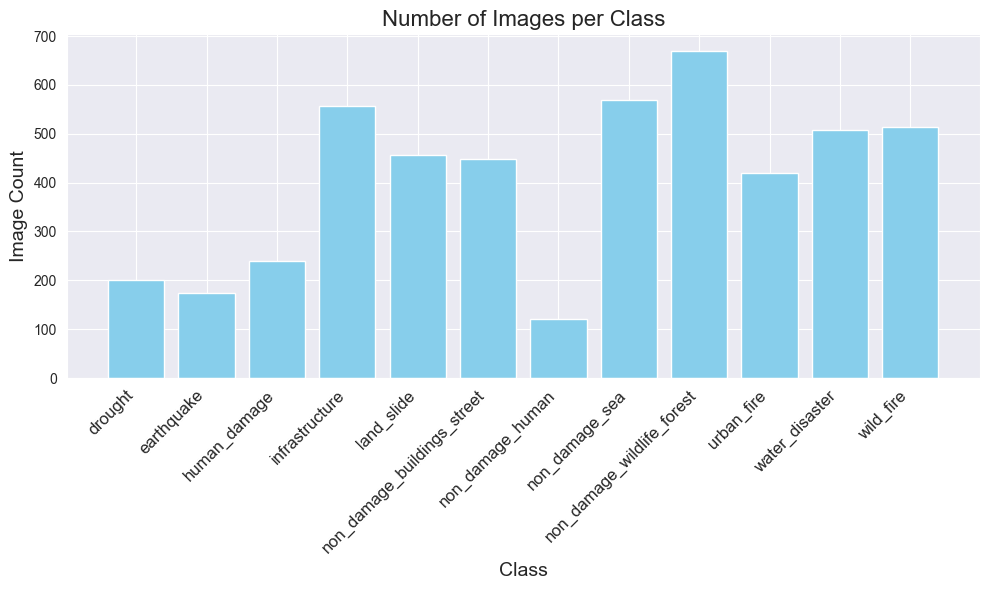

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(class_image_statistic['Class'], class_image_statistic['Image Count'], color='skyblue')

plt.title('Number of Images per Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Image Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

plt.show()

## Explore dimensions of images

In [8]:
def get_image_sizes(directory):
    widths, heights = [], []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        widths.append(width)
                        heights.append(height)
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")
    return widths, heights

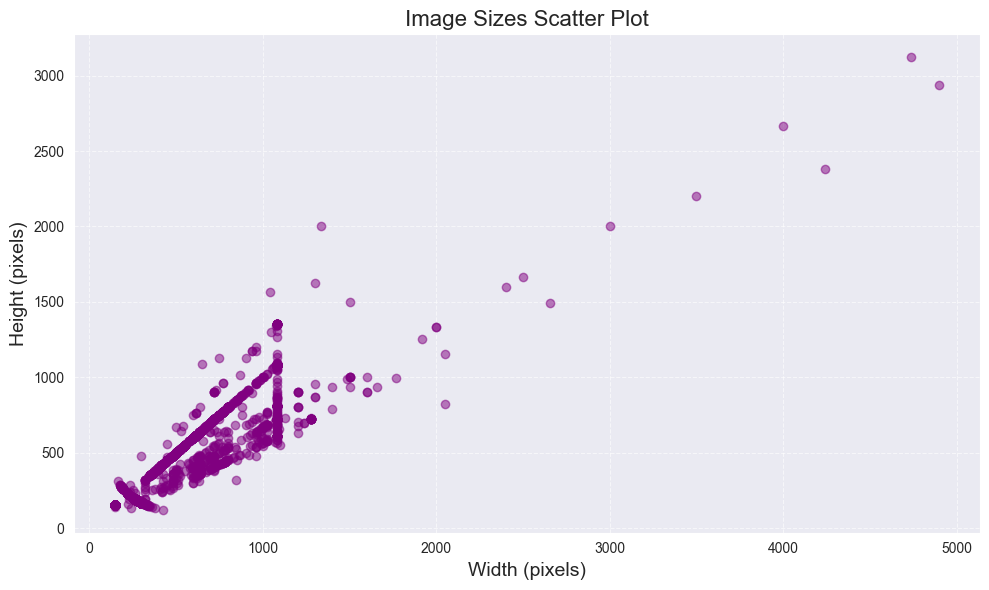

In [9]:
widths, heights = get_image_sizes(original_directory)

plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5, color='purple')
plt.title('Image Sizes Scatter Plot', fontsize=16)
plt.xlabel('Width (pixels)', fontsize=14)
plt.ylabel('Height (pixels)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

In [39]:
# INPUT_SIZE = (int(np.mean(widths)), int(np.mean(heights)))
# INPUT_SHAPE = (int(np.mean(widths)), int(np.mean(heights)), 3)
INPUT_SIZE = (200, 200)
INPUT_SHAPE = (200, 200, 3)
print(f"Input shape should be: {(int(np.mean(widths)), int(np.mean(heights)))}")

Input shape should be: (433, 382)


## Visualize images

In [11]:
def visualize_images_from_each_class(directory, classes, image_size=(150, 150)):
    num_classes = len(classes)
    fig, axes = plt.subplots(1, num_classes, figsize=(30, 10))
    
    for idx, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        image_name = os.listdir(class_path)[0]  
        image_path = os.path.join(class_path, image_name)
        
        img = Image.open(image_path).convert('RGB')
        img_resized = img.resize(image_size)
        
        axes[idx].imshow(img_resized)
        axes[idx].set_title(cls)
        axes[idx].axis('off') 
    plt.tight_layout()
    plt.show()

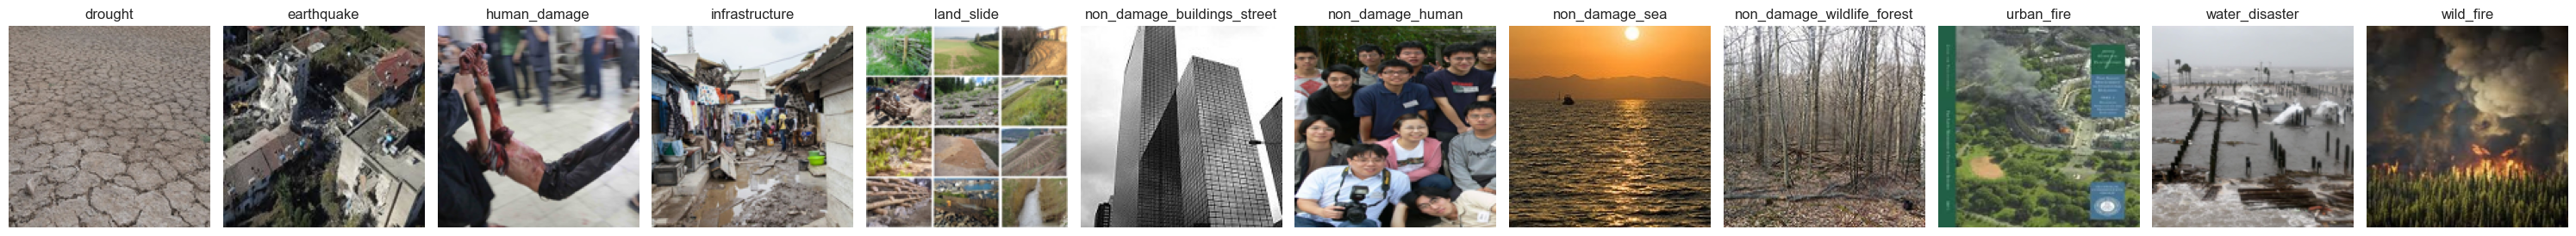

In [12]:
visualize_images_from_each_class(original_directory, classes)

# Split data for training, validation and testing

In [13]:
CLASSES_TO_KEEP = ["drought", "earthquake", "land_slide", "urban_fire", "water_disaster", "human_damage", "infrastructure"]
COMMON_IMAGE_COUNT = class_image_statistic[class_image_statistic['Class'].isin(CLASSES_TO_KEEP)]['Image Count'].min()
SPLIT_RATIOS = {'train': 0.7, 'valid': 0.2, 'test': 0.1}
COMMON_IMAGE_COUNT

174

In [14]:
def preprocess_and_split_data(original_directory, processed_directory, classes_to_keep, input_size, split_ratios, common_image_count):
    for cls in classes_to_keep:
        class_path = os.path.join(original_directory, cls)
        if not os.path.exists(class_path):
            print(f"Class {cls} does not exist in the dataset.")
            continue

        images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.png'))]
        random.shuffle(images)
        selected_images = images[:common_image_count]

        train, temp = train_test_split(selected_images, test_size=1 - split_ratios['train'], random_state=42)
        valid, test = train_test_split(temp, test_size=split_ratios['test'] / (split_ratios['valid'] + split_ratios['test']), random_state=42)

        splits = {'train': train, 'valid': valid, 'test': test}

        for split_name, split_images in splits.items():
            split_dir = os.path.join(processed_directory, split_name, cls)
            os.makedirs(split_dir, exist_ok=True)

            for img_name in split_images:
                img_path = os.path.join(class_path, img_name)
                try:
                    img = Image.open(img_path).convert('RGB')  
                    img_resized = img.resize(input_size)
                    save_path = os.path.join(split_dir, img_name)
                    img_resized.save(save_path)
                except Exception as e:
                    print(f"Error processing image {img_name}: {e}")

In [16]:
preprocess_and_split_data(original_directory, processed_directory, CLASSES_TO_KEEP, INPUT_SIZE, SPLIT_RATIOS, COMMON_IMAGE_COUNT)

## Split statistics

In [15]:
def plot_split_statistics(train_directory_param, valid_directory_param, test_directory_param, classes_param):
    def count_images_by_class(directory):
        class_counts = {}
        for cls in classes:
            class_path = os.path.join(directory, cls)
            if os.path.exists(class_path):
                class_counts[cls] = len(os.listdir(class_path))
            else:
                class_counts[cls] = 0
        return class_counts

    train_counts = count_images_by_class(train_directory_param)
    valid_counts = count_images_by_class(valid_directory_param)
    test_counts = count_images_by_class(test_directory_param)

    split_stats = pd.DataFrame({
        'Train': train_counts,
        'Valid': valid_counts,
        'Test': test_counts
    }).T  
    split_stats = split_stats[classes_param] 

    split_stats.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title('Number of Images per Class in Preprocess Splits', fontsize=14)
    plt.xlabel('Split', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Classes', loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()

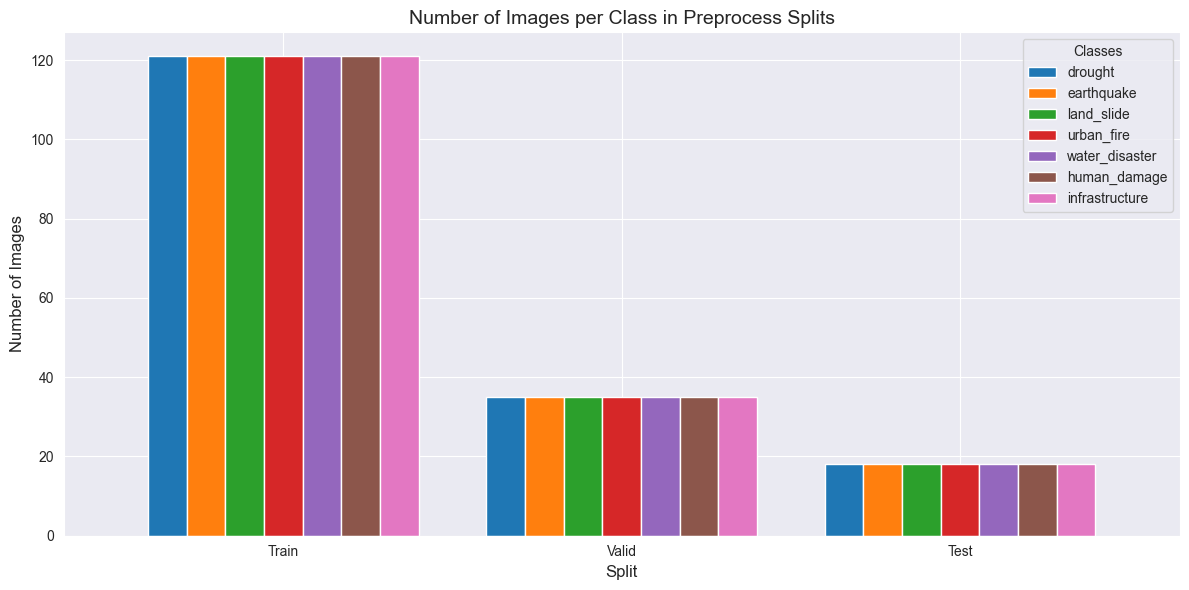

In [16]:
plot_split_statistics(train_directory, valid_directory, test_directory, CLASSES_TO_KEEP)

# CNN Method

## Prepare the data

In [17]:
BATCH_SIZE = 32 
IMAGE_SIZE = INPUT_SIZE  
tf.random.set_seed(42)

training_dataset = image_dataset_from_directory(
    train_directory,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode="int",  
    shuffle=True,
)

validation_dataset = image_dataset_from_directory(
    valid_directory,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode="int",  
    shuffle=True
)

testing_dataset = image_dataset_from_directory(
    test_directory,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode="int",  
    shuffle=True
)

Found 847 files belonging to 7 classes.
Found 245 files belonging to 7 classes.
Found 126 files belonging to 7 classes.


## Visualize from training dataset

In [18]:
def visualize_random_image(dataset):
    image_batch, label_batch = next(iter(dataset)) 
    
    random_index = np.random.randint(0, image_batch.shape[0])
    random_image = image_batch[random_index].numpy().astype("uint8") 
    random_label = label_batch[random_index].numpy()
    
    class_label = CLASSES_TO_KEEP[int(np.argmax(random_label))]
    
    plt.imshow(random_image)
    plt.title(f"Label: {class_label}")
    plt.axis('off')  
    plt.show()

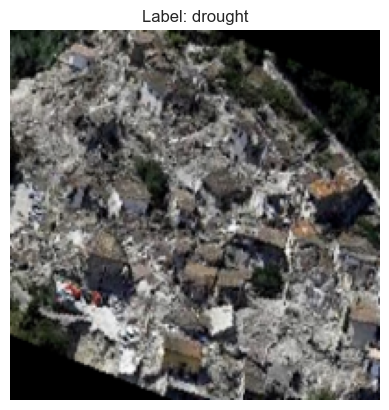

In [19]:
visualize_random_image(training_dataset)

## Normalize images

In [20]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

training_dataset = training_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
testing_dataset = testing_dataset.map(lambda x, y: (normalization_layer(x), y))

## Creating simple model

In [21]:
def build_model(input_size_param, num_classes_param):
    model = models.Sequential()
    
    model.add(layers.InputLayer(input_shape=(input_size_param[0], input_size_param[1], 3)))
    model.add(layers.Conv2D(32, (2, 2), activation='relu', padding='same')) 
    model.add(layers.MaxPooling2D((2, 2)))  
    
    model.add(layers.Conv2D(32, (2, 2), activation='relu', padding='same')) 
    model.add(layers.MaxPooling2D((2, 2))) 
    
    model.add(layers.Reshape((1, -1))) 
    model.add(layers.LSTM(256, activation='tanh', return_sequences=False))
    
    model.add(layers.Flatten())  
    
    model.add(layers.Dense(128, activation='relu')) 
    model.add(layers.Dropout(0.5)) 
    
    model.add(layers.Dense(num_classes_param, activation='softmax')) 
    
    return model

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=5000,
    decay_rate=0.9,
    staircase=True
)

num_classes = len(CLASSES_TO_KEEP) 
model = build_model(input_size_param=INPUT_SIZE, num_classes_param=num_classes)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

model.summary()

D:\Programs\Anaconda\envs\testing_env\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 80000)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │    82,183,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,221,511 (313.65 MB)

 Trainable params: 82,221,511 (313.65 MB)

 Non-trainable params: 0 (0.00 B)

## Fitting the model

In [22]:
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=15,  
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.1618 - loss: 2.1813 - val_accuracy: 0.3224 - val_loss: 1.8531
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2257 - loss: 1.8513 - val_accuracy: 0.4122 - val_loss: 1.6847
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.3694 - loss: 1.6893 - val_accuracy: 0.3796 - val_loss: 1.5555
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4625 - loss: 1.4367 - val_accuracy: 0.4694 - val_loss: 1.3581
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5778 - loss: 1.1232 - val_accuracy: 0.5592 - val_loss: 1.2610
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7272 - loss: 0.8263 - val_accuracy: 0.5429 - val_loss: 1.3106
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8272 - loss: 0.6000 - val_accuracy: 0.5837 - val_loss: 1.2681
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.9397 - loss: 0.2812 - val_accuracy: 0.5755 - val_loss:

## Collecting evaluation metrics and visualizing them

In [23]:
model_train_accuracy = history.history['accuracy']
model_val_accuracy = history.history['val_accuracy']
model_train_loss = history.history['loss']
model_val_loss = history.history['val_loss']

model_evaluation_dataframe = pd.DataFrame({
    'epoch': range(1, len(model_train_accuracy) + 1),
    'train_accuracy': model_train_accuracy,
    'val_accuracy': model_val_accuracy,
    'train_loss': model_train_loss,
    'val_loss': model_val_loss
})

model_evaluation_dataframe.head()

,epoch,train_accuracy,val_accuracy,train_loss,val_loss
0,1,0.170012,0.322449,2.041526,1.853104
1,2,0.240850,0.412245,1.819033,1.684737
2,3,0.399055,0.379592,1.626667,1.555478
3,4,0.510035,0.469388,1.346787,1.358079
4,5,0.612751,0.559184,1.066733,1.261027


In [24]:
def plot_all_metrics(metrics_df, title):
    plt.figure(figsize=(12, 8))
    plt.plot(metrics_df['epoch'], metrics_df['train_accuracy'], label='Train Accuracy', marker='o', color='blue')
    plt.plot(metrics_df['epoch'], metrics_df['val_accuracy'], label='Validation Accuracy', marker='o', color='orange')
    
    plt.plot(metrics_df['epoch'], metrics_df['train_loss'], label='Train Loss', marker='x', linestyle='--', color='green')
    plt.plot(metrics_df['epoch'], metrics_df['val_loss'], label='Validation Loss', marker='x', linestyle='--', color='red')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Metrics', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

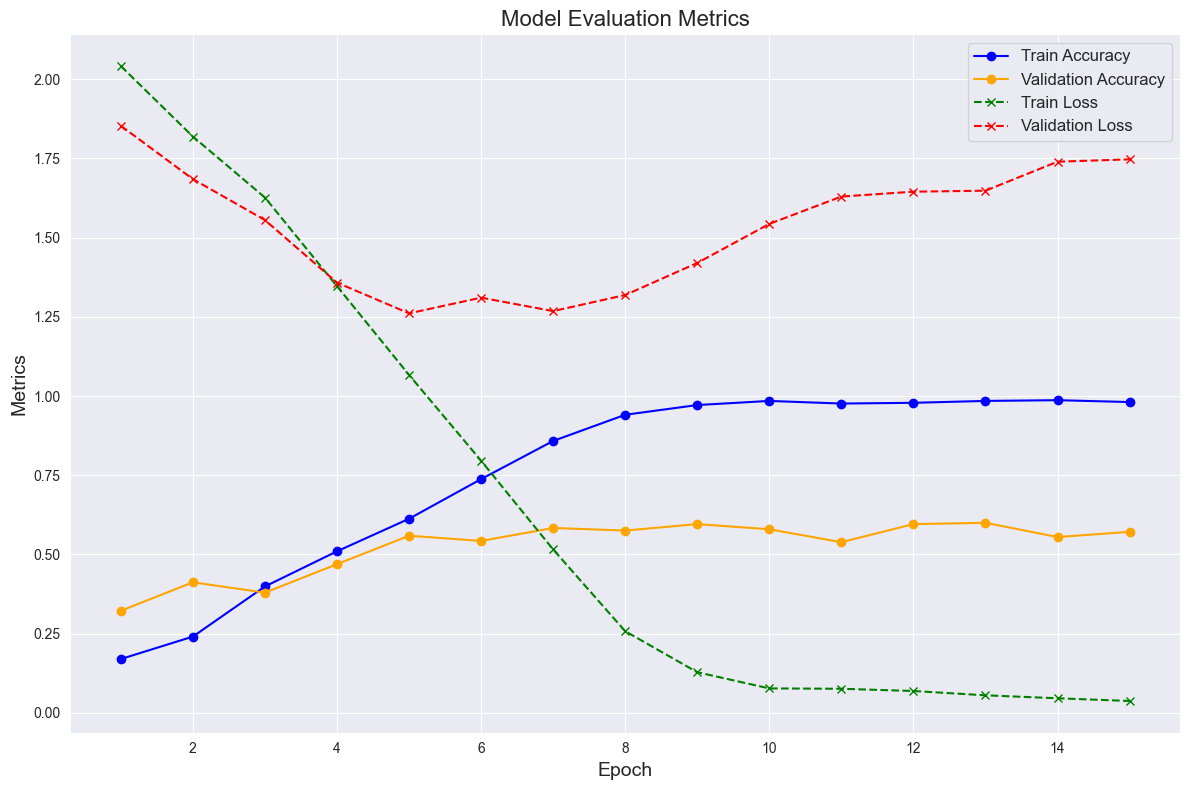

In [25]:
plot_all_metrics(model_evaluation_dataframe, "Model Evaluation Metrics")

## Evaluating on unseen data: testing dataset

In [28]:
test_loss, test_accuracy = model.evaluate(testing_dataset, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.6457 - loss: 1.4848
Test Loss: 1.4628669023513794
Test Accuracy: 0.6507936716079712


# Using SVM classifier

## Load and preprocess data 

In [29]:
def load_images_and_labels(directory_params, classes_params, input_size_params):
    images = []
    labels = []
    for class_label in classes_params:
        class_dir = os.path.join(directory_params, class_label)
        if os.path.exists(class_dir):
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                img = load_img(file_path, target_size=input_size_params)
                img_array = img_to_array(img) / 255.0  
                images.append(img_array.flatten()) 
                labels.append(class_label)
    return np.array(images), np.array(labels)

In [30]:
ml_training_data, ml_training_labels = load_images_and_labels(train_directory, CLASSES_TO_KEEP, INPUT_SIZE)
ml_validation_data, ml_validation_labels = load_images_and_labels(valid_directory, CLASSES_TO_KEEP, INPUT_SIZE)
ml_testing_data, ml_testing_labels = load_images_and_labels(test_directory, CLASSES_TO_KEEP, INPUT_SIZE)

ml_training_data.shape, ml_validation_data.shape, ml_testing_data.shape

((847, 120000), (245, 120000), (126, 120000))

In [31]:
label_encoder = LabelEncoder()
ml_training_labels_encoded = label_encoder.fit_transform(ml_training_labels)
ml_validation_labels_encoded = label_encoder.transform(ml_validation_labels)
ml_testing_labels_encoded = label_encoder.transform(ml_testing_labels)

## Find the best parameters

In [37]:
svm = SVC()

svc_param_grid = {
    'C': [0.1, 1, 10, 100], 
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 'auto', 0.01, 0.001] 
}

svc_grid_search = GridSearchCV(estimator=svm, param_grid=svc_param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)
svc_grid_search.fit(ml_training_data, ml_training_labels_encoded)

svc_best_params = svc_grid_search.best_params_
svc_best_score = svc_grid_search.best_score_

print(f"Best Parameters: {svc_best_params}")
print(f"Best Cross-Validation Accuracy: {svc_best_score:.4f}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.4581


## Evaluate on test set

In [41]:
best_svc_model = svc_grid_search.best_estimator_
svc_testing_predictions = best_svc_model.predict(ml_testing_data)

print("Testing Accuracy: {:.2f}%".format(accuracy_score(ml_testing_labels_encoded, svc_testing_predictions) * 100))
print("\nClassification Report:\n")
print(classification_report(ml_testing_labels_encoded, svc_testing_predictions, target_names=CLASSES_TO_KEEP))

Testing Accuracy: 49.21%

Classification Report:

                precision    recall  f1-score   support

       drought       0.62      0.72      0.67        18
    earthquake       0.68      0.83      0.75        18
    land_slide       0.59      0.56      0.57        18
    urban_fire       0.39      0.50      0.44        18
water_disaster       0.17      0.17      0.17        18
  human_damage       0.62      0.28      0.38        18
infrastructure       0.41      0.39      0.40        18

      accuracy                           0.49       126
     macro avg       0.50      0.49      0.48       126
  weighted avg       0.50      0.49      0.48       126


<Figure size 1000x800 with 0 Axes>

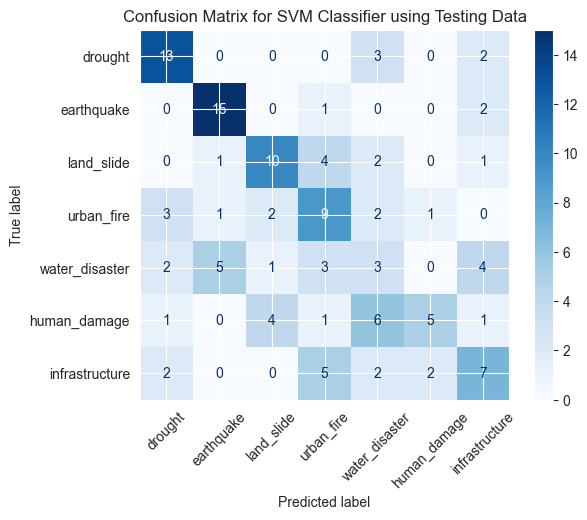

In [42]:
svc_testing_confusion_matrix = confusion_matrix(ml_testing_labels_encoded, svc_testing_predictions)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=svc_testing_confusion_matrix, display_labels=CLASSES_TO_KEEP)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for SVM Classifier using Testing Data")
plt.xticks(rotation=45)
plt.show()

# Using Random Forest

## Find the best parameters

In [43]:
random_forest = RandomForestClassifier(random_state=42)

random_forest_param_grid = {
    'n_estimators': [50, 100, 200],      
    'max_depth': [None, 10, 20, 30],    
    'min_samples_split': [2, 5, 10],    
    'min_samples_leaf': [1, 2, 4]       
}

random_forest_grid_search = GridSearchCV(
    estimator=random_forest,
    param_grid=random_forest_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1  
)

random_forest_grid_search.fit(ml_training_data, ml_training_labels_encoded)
print("Best Parameters:", random_forest_grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [44]:
random_forest_best_score = random_forest_grid_search.best_score_
print(f"Best Cross-Validation Accuracy: {random_forest_best_score:.4f}")

Best Cross-Validation Accuracy: 0.4629


## Evaluate on test set

In [45]:
best_random_forest_model = random_forest_grid_search.best_estimator_
random_forest_testing_predictions = best_random_forest_model.predict(ml_testing_data)

print("Testing Accuracy: {:.2f}%".format(accuracy_score(ml_testing_labels_encoded, random_forest_testing_predictions) * 100))
print("\nClassification Report:\n")
print(classification_report(ml_testing_labels_encoded, random_forest_testing_predictions, target_names=CLASSES_TO_KEEP))

Testing Accuracy: 50.79%

Classification Report:

                precision    recall  f1-score   support

       drought       0.70      0.78      0.74        18
    earthquake       0.74      0.94      0.83        18
    land_slide       0.55      0.33      0.41        18
    urban_fire       0.30      0.33      0.32        18
water_disaster       0.33      0.33      0.33        18
  human_damage       0.50      0.33      0.40        18
infrastructure       0.41      0.50      0.45        18

      accuracy                           0.51       126
     macro avg       0.50      0.51      0.50       126
  weighted avg       0.50      0.51      0.50       126


<Figure size 1000x800 with 0 Axes>

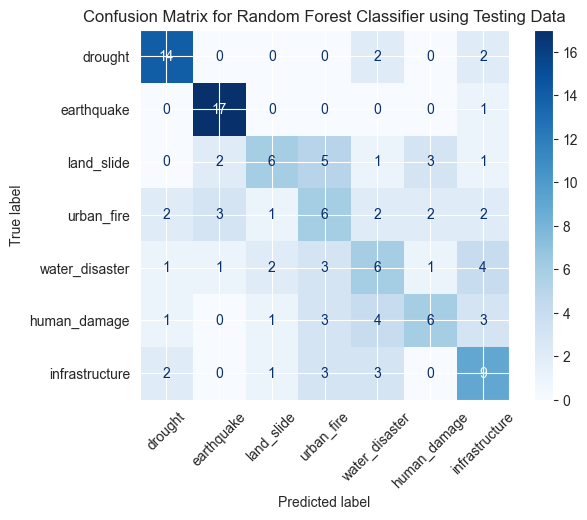

In [46]:
random_forest_confusion_matrix = confusion_matrix(ml_testing_labels_encoded, random_forest_testing_predictions)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=random_forest_confusion_matrix, display_labels=CLASSES_TO_KEEP)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for Random Forest Classifier using Testing Data")
plt.xticks(rotation=45)
plt.show()